Load environment variables from .env file

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

Download md files from Adguard knowledge base repo

In [2]:
import os
# github v3 API
from github import Github


github = Github(os.getenv('GITHUB_API_TOKEN'))

repo_name = "AdguardTeam/KnowledgeBase"
repo_src_dir = "docs"
data_dir = "data"

repo = github.get_repo(repo_name)

# if data_dir does not exist, create it
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
contents = repo.get_contents(repo_src_dir)

for content in contents:
    if content.type == "dir":
        contents.extend(repo.get_contents(content.path))
    elif content.type == "file" and content.path.endswith(".md"):
        with open(os.path.join(os.getcwd(), data_dir, content.sha), 'wb') as f:
            f.write(content.decoded_content)
            print('Downloaded ' + content.path)         

Downloaded docs/intro.md
Downloaded docs/adguard-browser-extension/installation.md
Downloaded docs/adguard-browser-extension/integration-mode.md
Downloaded docs/adguard-browser-extension/overview.md
Downloaded docs/adguard-content-blocker/installation.md
Downloaded docs/adguard-content-blocker/overview.md
Downloaded docs/adguard-for-android/installation.md
Downloaded docs/adguard-for-android/overview.md
Downloaded docs/adguard-for-ios/installation.md
Downloaded docs/adguard-for-ios/overview.md
Downloaded docs/adguard-for-ios/web-extension.md
Downloaded docs/adguard-for-mac/browser-assistant.md
Downloaded docs/adguard-for-mac/installation.md
Downloaded docs/adguard-for-mac/overview.md
Downloaded docs/adguard-for-safari/installation.md
Downloaded docs/adguard-for-safari/overview.md
Downloaded docs/adguard-for-windows/admins-documentation.md
Downloaded docs/adguard-for-windows/browser-assistant.md
Downloaded docs/adguard-for-windows/installation.md
Downloaded docs/adguard-for-windows/over

Preprocess text data from markdown files and save it to a CSV file

In [3]:
import re
# HTML parser
from bs4 import BeautifulSoup
# Markdown parser
from marko import Markdown
# Github flavored markdown parser extension
from marko.ext.gfm import GFM
import pandas as pd

dist_dir = "dist"
text_csv_file_path = "scraped.csv"

markdown = Markdown(extensions=[GFM()])

texts=[]

for file in os.listdir(data_dir):
    with open(os.path.join(data_dir, file), "r") as f:
        # Omit the first 4 lines of markdown front matter
        for i in range(4):
             f.readline()
        
        # read the rest of the file
        markdown_string = f.read()

        # md -> html -> text since BeautifulSoup can extract text cleanly
        html = markdown.convert(markdown_string)

        # extract text
        soup = BeautifulSoup(html, "html.parser")

        text = ''.join(soup.findAll(string=True))

        # remove newlines
        text = text.replace('\n', ' ')

        # remove extra whitespaces
        text = re.sub('\s+', ' ', text)

        texts.append(text)

df = pd.DataFrame(texts, columns=["text"])


# if dist_dir does not exist, create it
if not os.path.exists(dist_dir):
    os.mkdir(dist_dir)

df.to_csv(os.path.join(dist_dir, text_csv_file_path))
df.head(10)

,text
0,How to reach the Low-level settings Changing L...
1,There are five major AdGuard projects on Crowd...
2,How to install AdGuard Browser extension for G...
3,We have written this article to avoid confusio...
4,In a nutshell Apple's Mail app now uses a prox...
5,This page describes the features and details o...
6,"AdGuard for Mac, as one of our main staples, m..."
7,"Previously known as low-level settings, Advanc..."
8,What is AdGuard license A license is permissio...
9,"The owners of phones, tablets, or TVs running ..."


<Axes: >

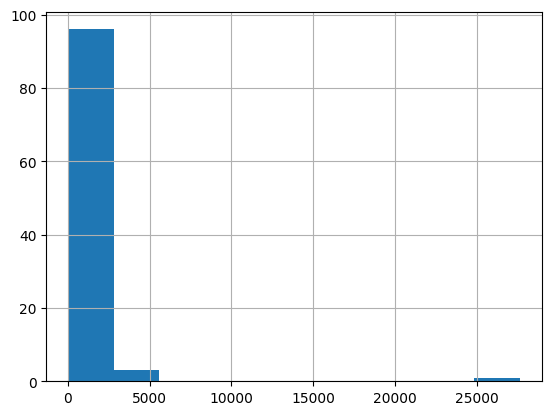

In [5]:

import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv(os.path.join(dist_dir, text_csv_file_path), index_col=0)
df.columns = ['text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [6]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_text(text: str, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_text(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

Visualising the updated histogram again can help to confirm that the lines have been successfully split into chunks:

<Axes: >

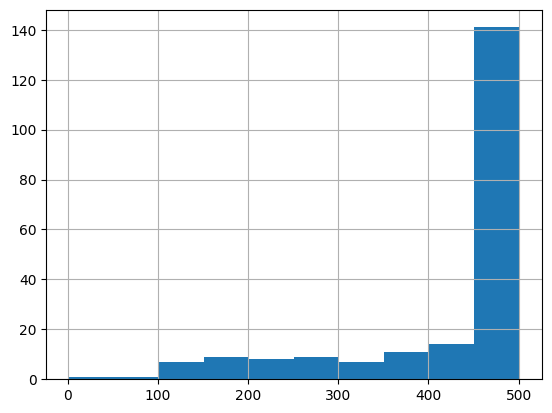

In [7]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

Create the chunked text embeddings via the OpenAI API, specifying the use of the new `text-embedding-ada-002` model:

In [8]:
import openai

openai.api_key = os.getenv('OPENAI_API_KEY')

embedding_csv_file_name = "embeddings.csv"

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv(os.path.join(dist_dir, embedding_csv_file_name))
df.head()

,text,n_tokens,embeddings
0,How to reach the Low-level settings Changing L...,491,"[0.013656668365001678, 0.014598741196095943, 0..."
1,There are five major AdGuard projects on Crowd...,281,"[0.0067566619254648685, 0.004292031284421682, ..."
2,How to install AdGuard Browser extension for G...,282,"[0.02430276945233345, 0.01311484444886446, 0.0..."
3,We have written this article to avoid confusio...,487,"[0.021347705274820328, 0.0033652286510914564, ..."
4,In a nutshell Apple's Mail app now uses a prox...,452,"[-0.004872484598308802, -0.0064920708537101746..."


In [9]:
import numpy as np

df=pd.read_csv(os.path.join(dist_dir, embedding_csv_file_name), index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,How to reach the Low-level settings Changing L...,491,"[0.013656668365001678, 0.014598741196095943, 0..."
1,There are five major AdGuard projects on Crowd...,281,"[0.0067566619254648685, 0.004292031284421682, ..."
2,How to install AdGuard Browser extension for G...,282,"[0.02430276945233345, 0.01311484444886446, 0.0..."
3,We have written this article to avoid confusio...,487,"[0.021347705274820328, 0.0033652286510914564, ..."
4,In a nutshell Apple's Mail app now uses a prox...,452,"[-0.004872484598308802, -0.0064920708537101746..."


In [13]:
from openai.embeddings_utils import distances_from_embeddings

max_question_len=1800

# Create a context for a question by finding the most similar context from the dataframe
def create_context(question: str, df: pd.DataFrame):
    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    current_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        current_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if current_len > max_question_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [14]:
# Answer a question based on the most similar context from the dataframe texts
def answer_question(question: str, df: pd.DataFrame):
    context = create_context(question, df)

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            model="text-davinci-003",
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=150,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=None,
           
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [16]:
answer_question("What day is it?", df)

"I don't know."

In [17]:
answer_question("What is Adguard browser extension?", df)

"AdGuard Browser extension is a free extension that works in five popular browsers: Chrome, Firefox, Edge, Opera, and Yandex Browser. It provides basic ad-blocking features and can be found in the browser’s online store or on AdGuard's official website. It also offers additional features such as DNS filtering, Parental Control, Filtering log, and more."